In [286]:
### Preamble
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ML_util as util
from astropy.table import Table
from importlib import reload
import plot_util as p_util
import keck_data_compiler as comp

data_dir = "data/"
steve_file = data_dir+"lgs_metadata.fits"
plot_dir = "plots/"
steve_plots = plot_dir+"steve_plots/"

In [287]:
### Read in Steve's data
data = Table.read(steve_file, format='fits')
steve_data = data.to_pandas()
print(steve_data.columns)
steve_data.describe()

Index(['file', 'strehl', 'rms_err', 'fwhm', 'mjd', 'epoch', 'airmass', 'itime',
       'coadds', 'band', 'az', 'dmgain', 'dtgain', 'wsfrrt', 'aolbfwhm',
       'lsamppwr', 'lgrmswf', 'xref', 'yref', 'xstrehl', 'ystrehl', 'MASS',
       'MASS_mjd', 'MASS_delta_t', 'DIMM', 'DIMM_mjd', 'DIMM_delta_t',
       'MASSPRO_half', 'MASSPRO_1', 'MASSPRO_2', 'MASSPRO_4', 'MASSPRO_8',
       'MASSPRO_16', 'MASSPRO', 'MASSPRO_mjd', 'MASSPRO_delta_t',
       'wind_speed[kts]', 'wind_speed', 'wind_direction', 'temperature',
       'relative_humidity', 'pressure[mb]', 'pressure', 'cfht_mjd',
       'cfht_delta_t'],
      dtype='object')


,strehl,rms_err,fwhm,mjd,airmass,itime,coadds,az,dmgain,dtgain,...,MASSPRO_delta_t,wind_speed[kts],wind_speed,wind_direction,temperature,relative_humidity,pressure[mb],pressure,cfht_mjd,cfht_delta_t
count,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.000000,...,3281.000000,5949.000000,5949.000000,5949.000000,5949.000000,5949.00000,5949.000000,5949.000000,5949.000000,5949.000000
mean,0.281083,383.117079,67.839193,56117.752875,1.583200,2.805354,10.339385,177.907009,0.297084,0.104504,...,-0.225573,11.676542,6.006932,-221.363591,2.357018,23.33720,618.047067,0.618047,56117.748694,0.004181
std,0.100528,51.807862,19.021460,1305.547327,0.094087,0.344479,5.939079,15.797041,0.078659,0.089278,...,0.480427,8.482568,4.363810,1830.418981,1.988321,18.10659,2.042654,0.002043,1305.544130,0.066346
min,-1.000000,-1.000000,-1.000000,53212.346420,1.515730,0.181000,3.000000,138.497840,0.200000,0.010000,...,-1.781127,0.000000,0.000000,-10000.000000,-3.290000,2.00000,611.900000,0.611900,53212.347222,-0.001988
25%,0.233000,350.100000,58.330000,55036.327970,1.524350,2.800000,10.000000,165.695560,0.250000,0.050000,...,-0.006460,5.220000,2.685400,65.000000,1.040000,10.00000,616.700000,0.616700,55036.329167,-0.000220
50%,0.292000,374.700000,63.630000,56132.355430,1.551410,2.800000,10.000000,179.373300,0.250000,0.075000,...,-0.000206,11.000000,5.658889,94.000000,2.450000,16.00000,618.300000,0.618300,56132.355556,0.000007
75%,0.342000,407.600000,72.150000,57243.317310,1.605690,2.800000,10.000000,191.085560,0.350000,0.100000,...,0.000267,16.520000,8.498622,137.000000,3.730000,34.00000,619.600000,0.619600,57243.317361,0.000226
max,0.615000,722.900000,442.630000,57991.296820,2.268440,8.000000,120.000000,204.037230,0.600000,0.500000,...,0.102330,36.520000,18.787511,355.000000,6.880000,80.00000,622.400000,0.622400,57991.296528,1.204238


Text(0, 0.5, 'Have data')

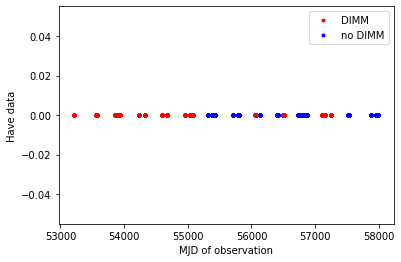

In [67]:
### Methods section figure: Data Sets
### Which NIRC2 observations have weather, seeing, and telemetry data
seeing_invalid = steve_data.DIMM_mjd.isnull().values
seeing_invalid = seeing_invalid.astype(float)
seeing_invalid[seeing_invalid==1] = np.nan

plt.plot(steve_data.mjd, steve_data.mjd.isnull().values, 'r.', label="DIMM")
plt.plot(steve_data.DIMM_mjd, seeing_invalid, 'b.', label="no DIMM")
plt.legend()

plt.xlabel("MJD of observation")
plt.ylabel("Have data")

In [213]:
comp.update()

Message: NIRC2 file found: /g/lu/data/gc/lgs_data/04jullgs/clean/kp/


AOOPSMODE= '2       '           / AO General Ops Mode                            [astropy.io.fits.card]
AOOPSMODE= '2       '           / AO General Ops Mode                           


	Message: Retrieved weather data for all files
Message: NIRC2 file found: /g/lu/data/gc/lgs_data/05jullgs/clean/kp/
	Message: Retrieved weather data for all files
Message: NIRC2 file found: /g/lu/data/gc/lgs_data/05junlgs/clean/kp/
	Message: Retrieved weather data for all files
Message: NIRC2 file found: /g/lu/data/gc/lgs_data/06auglgs/clean/kp/
Error: No Strehl file found for epoch 06auglgs. Exiting.
Message: NIRC2 file found: /g/lu/data/gc/lgs_data/06jullgs/clean/kp/
	Message: Retrieved weather data for all files
Message: NIRC2 file found: /g/lu/data/gc/lgs_data/06junlgs/clean/kp/
	Message: Retrieved weather data for all files
Message: NIRC2 file found: /g/lu/data/gc/lgs_data/06maylgs1/clean/kp/
	Message: Retrieved weather data for all files
Message: NIRC2 file found: /g/lu/data/gc/lgs_data/06maylgs2/clean/kp/
	Message: Retrieved weather data for all files
Message: NIRC2 file found: /g/lu/data/gc/lgs_data/07auglgs/clean/kp/
	Message: Retrieved weather data for all files
Message: NIRC

In [288]:
### Read in my data
reload(util)
data = pd.read_csv(data_dir+"keck_metadata.dat")
data = util.clean(data)
data.columns = [x.lower() for x in data.columns]
data.columns

Index(['file', 'strehl', 'rms_err', 'fwhm', 'mjd', 'epoch', 'airmass', 'itime',
       'coadds', 'fwiname', 'az', 'dmgain', 'dtgain', 'xref', 'yref',
       'xstrehl', 'ystrehl', 'wsfrrt', 'aolbfwhm', 'lsamppwr', 'lgrmswf',
       'mass_mjd', 'dimm_mjd', 'masspro_mjd', 'cfht_mjd', 'mass', 'dimm',
       'masspro_half', 'masspro_1', 'masspro_2', 'masspro_4', 'masspro_8',
       'masspro_16', 'masspro', 'wind_speed', 'wind_direction', 'temperature',
       'relative_humidity', 'pressure'],
      dtype='object')

In [293]:
reload(p_util)

<module 'plot_util' from '/u/emily_ramey/work/Keck_Performance/plot_util.py'>

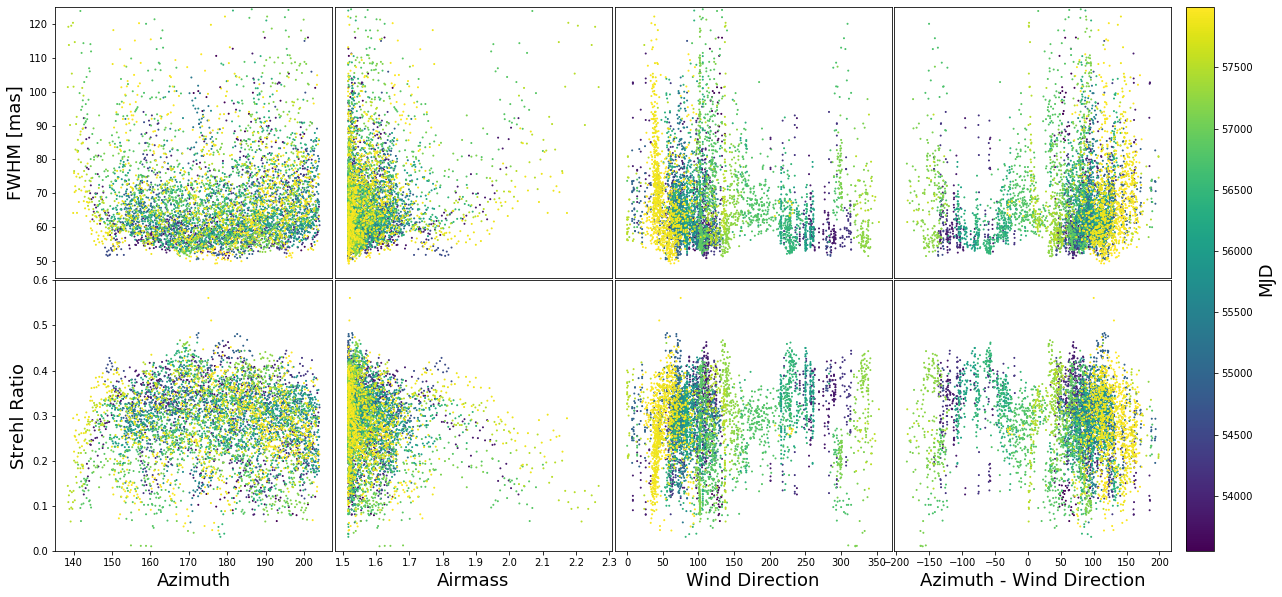

In [295]:
### First data-on-data plot:
### Azimuth, Airmass, Wind Direction, Azimuth - Wind Direction vs. image quality
settings = p_util.default_settings.copy()
settings['label'].update({'az-wdir':'Azimuth - Wind Direction'})
data['az-wdir'] = data['az']-data['wind_direction']
x_vars = ['az', 'airmass', 'wind_direction', 'az-wdir']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='mjd', fontsize=18, settings=settings)

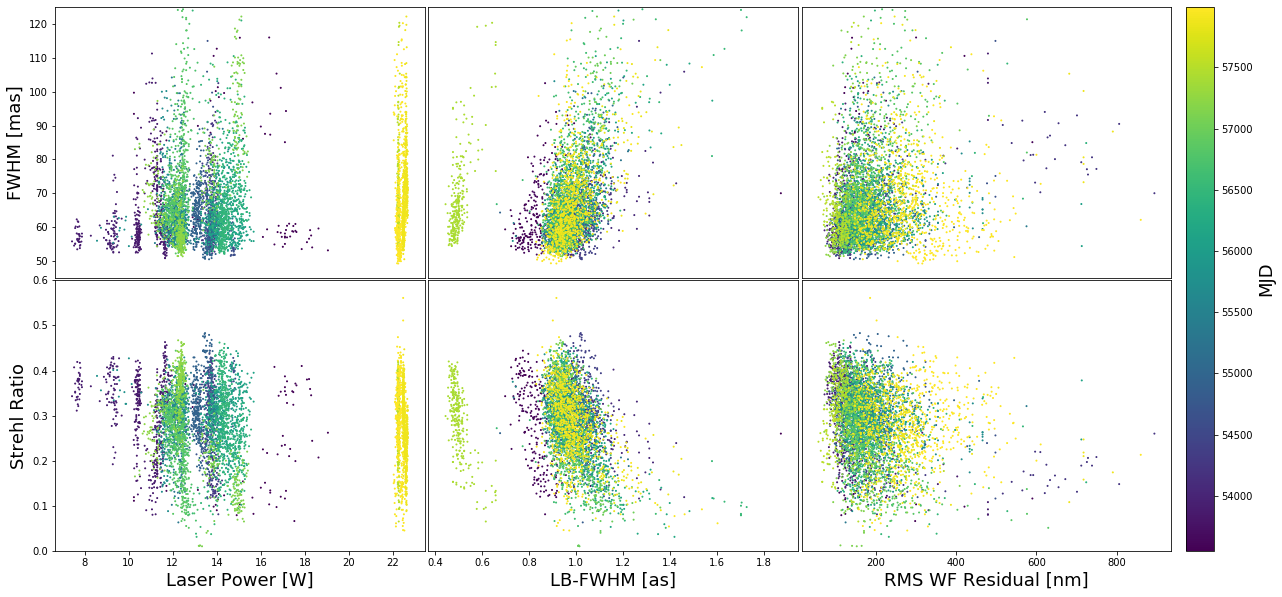

In [297]:
### Second data-on-data plot:
### Should be AOAOMED, LSAMPPWR, AOLBFWHM, LGRMSWF vs. strehl and fwhm, but AOAOMED is missing
x_vars = ['lsamppwr', 'aolbfwhm', 'lgrmswf']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='mjd', fontsize=18)

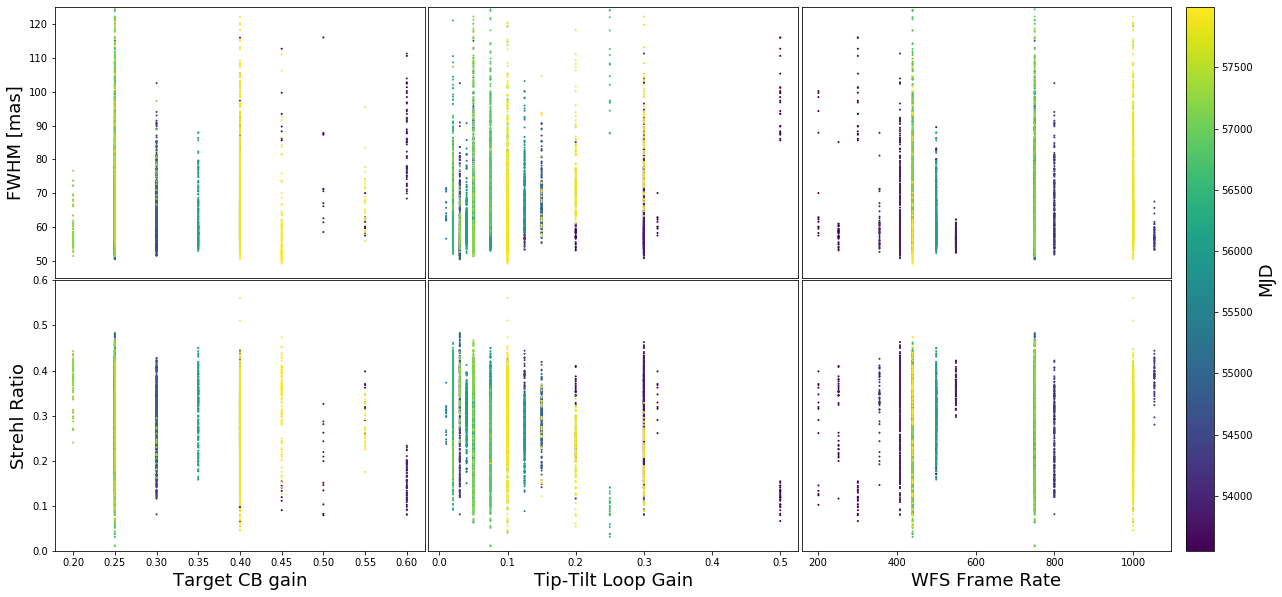

In [298]:
### Third data-on-data plot:
### Should be tubetemp, dmgain, dtgain, and wsfrrt, but tubetemp is missing
x_vars = ['dmgain', 'dtgain', 'wsfrrt']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='mjd', fontsize=18)

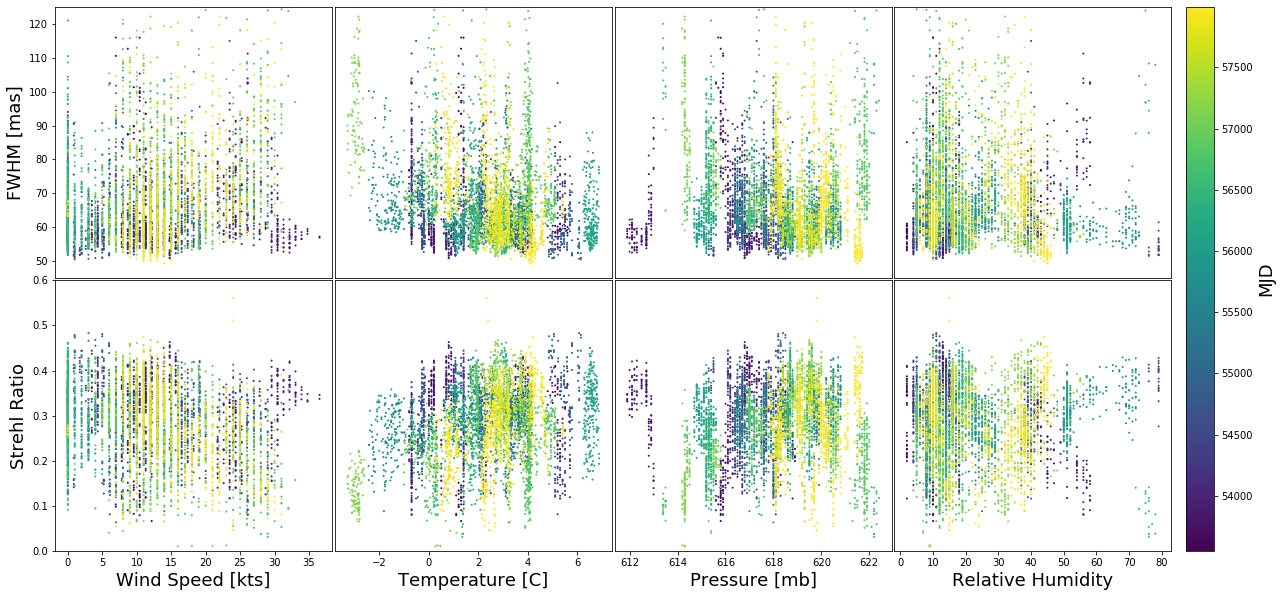

In [299]:
x_vars = ['wind_speed', 'temperature', 'pressure', 'relative_humidity']
y_vars = ['fwhm', 'strehl']
p_util.plot_vars(data, x_vars, y_vars, c_var='mjd', fontsize=18, save=True)

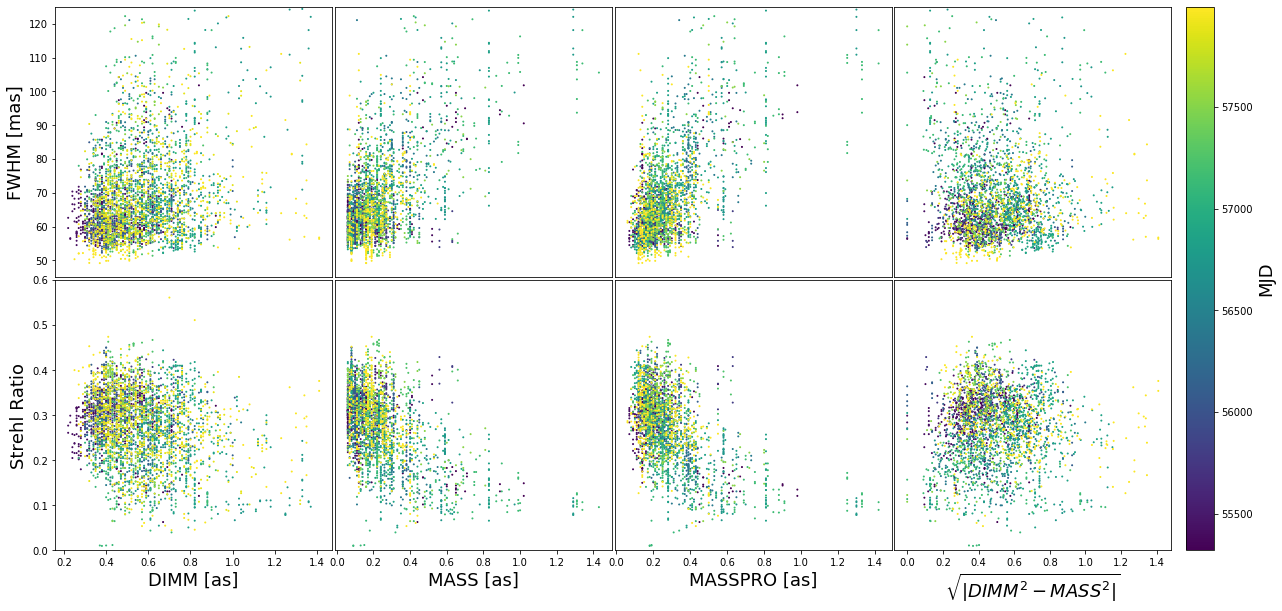

In [301]:
settings = p_util.default_settings.copy()
settings['label'].update({'sqrt-d2-m2':'$\sqrt{|DIMM^2-MASS^2|}$'})
data['sqrt-d2-m2'] = np.sqrt(np.abs(data.dimm**2 - data.mass**2))
x_vars = ['dimm', 'mass', 'masspro', 'sqrt-d2-m2']
y_vars = ['fwhm', 'strehl']

p_util.plot_vars(data, x_vars, y_vars, c_var='mjd', settings=settings, fontsize=18)

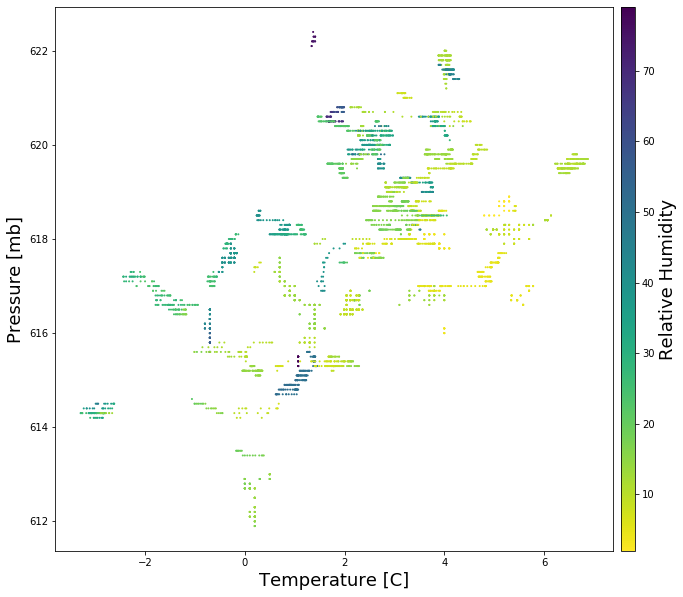

In [277]:
x_vars = ['temperature']
y_vars = ['pressure']
p_util.plot_vars(data, x_vars, y_vars, c_var='relative_humidity', fontsize=18, figsize=(10, 10), cmap='viridis_r',
                 save=False)